# apply instruments settings

In [28]:
import time
import sys
import os
path_project = "\\".join(os.getcwd().split("\\")[:-1])
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, path_project)

from hardware.pulser.pulser import PulseGenerator, OutputState, TriggerStart, TriggerRearm, HIGH, LOW, INF, REPEAT_INFINITELY
from hardware.laser.laser import LaserControl
from hardware.mw.mwsynthesizer import Synthesizer

from hardware import config_custom as hcf

import nidaqmx
from nidaqmx.constants import TerminalConfiguration, VoltageUnits, Edge, AcquisitionType, READ_ALL_AVAILABLE, TaskMode
# from nidaqmx.constants import LogicFamily 
# TWO_POINT_FIVE_V, THREE_POINT_THREE_V, FIVE_V
# from nidaqmx import stream_readers 
from nidaqmx.stream_readers import AnalogSingleChannelReader, DigitalSingleChannelReader

import numpy as np

In [29]:
# connect to devices
pg  = PulseGenerator(ip=hcf.PS_IP, 
                     chmap=hcf.PS_chmap,
                     choffs=hcf.PS_choffs) 
mwsyn = Synthesizer(hcf.VDISYN_SN, 
                    vidpid=hcf.VDISYN_VIDPID,
                    baudrate=hcf.VDISYN_BAUD, 
                    timeout=5, 
                    write_timeout=5)
# mwsyn.reboot()
laser = LaserControl(hcf.LASER_SN)
laser.open()


Connect to Pulse Streamer via JSON-RPC.
IP / Hostname: 169.254.8.2
Pulse Streamer 8/2 firmware: v1.7.2
Client software: v1.7.0
VDI Sythesizer Serail Port Open


# Set parameters

In [30]:
current_percent = 80.09
# current_percent = 0.051
laser.laser_off()
laser.set_analog_control_mode("current")
laser.set_modulation_state("Pulsed")
laser.set_diode_current(current_percent, save_memory=False)

In [31]:
# set MW power =====================================================
mwpower_vlevel = 5.0 # 5V equals to max power
task_uca = nidaqmx.Task("UCA") # user controlled attenuation
task_uca.ao_channels.add_ao_voltage_chan(hcf.NI_ch_UCA, min_val=0, max_val=10)
# task_uca.timing.cfg_samp_clk_timing(hcf.NI_sampling_max/100.0, sample_mode=AcquisitionType.CONTINUOUS)
task_uca.start()
task_uca.write([mwpower_vlevel], auto_start=False)
# task_uca.stop()
# task_uca.close()

1

In [32]:
timebase = np.lcm(hcf.NI_timebase, hcf.VDISYN_timebase)

init_laser = 2200.0
init_wait = 1000.0
mw_time = 2000.0
read_wait = 500.0
read_laser = 1200.0

def seqtime(seq_tb):
    return np.sum([pulse[-1] for pulse in seq_tb])


sub_init = [(["laser"], init_laser), ([], init_wait)]
sub_initnolaser = [([], init_laser), ([], init_wait)]
sub_mw = [(["mwB"],mw_time)]
sub_nomw = [([],mw_time)]
sub_read = [([], read_wait), (["laser", "dclk"], read_laser)]
sub_readnolaser = [([], read_wait), (["dclk"], read_laser)]
seqlet_mw = sub_init+sub_mw+sub_read
seqlet_nomw = sub_init+sub_nomw+sub_read
seqlet_time = seqtime(seqlet_mw)

halfsteptime = int((seqlet_time+10*timebase)/timebase)*timebase
steptime = 2*halfsteptime
sub_trig = [(["dtrig"], halfsteptime-seqlet_time)]
sub_pad = [([], halfsteptime-seqlet_time)]


In [33]:
# f_NVguess = 392.83677300810814
f_NVguess = 398.5607725381851
freq_start = (f_NVguess-0.020)/24.0
freq_stop = (f_NVguess+0.020)/24.0
step_min = mwsyn.get_min_step_size([freq_start], [freq_stop])[0] # in Hz
freq_step = 0.2E-3/24.0
freq_step = int(freq_step/step_min*1E9)*step_min/1E9
step_rise = freq_step
step_fall = freq_step

# steptime = 16.0E3 # [ns]
# steptime = int(steptime/timebase)*timebase
steptime_rise = steptime 
steptime_fall = steptime

dwellatlow = False
dwellathigh = False
num_risesweep = int((freq_stop-freq_start)/step_rise)+1
num_fallsweep = int((freq_stop-freq_start)/step_fall)+1
print(f"Approximated Time to Sweep along rise direction: \n{(freq_stop-freq_start)/step_rise*steptime_rise/1E6}ms")

actualpara = mwsyn.sweep(freq_start, freq_stop, 
                         step_rise, step_fall, 
                         steptime_rise, steptime_fall, 
                         dwellatlow, dwellathigh)

(freq_start_actual, freq_stop_actual, step_rise_actual, step_fall_actual) = actualpara
freq_actual_rise = 24.0*np.arange(freq_start_actual, freq_stop_actual+step_rise_actual, step_rise_actual)
freq_actual_fall = 24.0*np.flip(np.arange(freq_start_actual+step_rise_actual, freq_stop_actual, step_fall_actual))
freq_sawsweep = np.append(freq_actual_rise, freq_actual_fall)
num_freqsaw = len(freq_sawsweep)

Approximated Time to Sweep along rise direction: 
5.692627651129828ms


In [34]:
num_freqsaw*steptime

11388400

In [35]:
print(freq_actual_rise[0])
print(freq_actual_rise[-1])
print(freq_actual_fall[0])
print(freq_actual_fall[-1])

398.5407726466656
398.58078369498253
398.5806839168072
398.5408724248409


In [36]:
seq_exp = []
# seqlet_mw = sub_init + sub_mw + sub_readnolaser
# seqlet_nomw = sub_init + sub_nomw + sub_read
seq_exp += (sub_trig+seqlet_mw+sub_pad+seqlet_nomw)
seq_exp += (sub_pad+seqlet_mw+sub_pad+seqlet_nomw)*(num_freqsaw-1)

pg.seqTranslator(seq_exp)
pg.plotSeq(plot_all=False)

In [37]:
seqtime(seq_exp)

11388400.0

In [38]:
# start frequency sweep
mwsyn.reset_trigger()
mwsyn.sweep_continue()
# time.sleep(5) #sweep for 5s


b'U'

In [39]:
# clock_rate = 2/steptime #[GHz]
# # dur_pt = (freq_stop-freq_start)*(steptime_rise/step_rise+steptime_fall/step_fall) +steptime_rise + steptime_fall# [ns]
# laser_time = 1200
# mw_time = 1500
# time_fullsweep = steptime*num_freqsaw

# seq_daqtrig = [(2*timebase, HIGH), (steptime*num_freqsaw-timebase*10, LOW)]
# # seq_laser = [(time_fullsweep, HIGH)]
# # seq_mwA = [(time_fullsweep, HIGH)]
# seq_laser = [(steptime/2.0, LOW), (steptime/4.0, HIGH),(steptime/4.0, HIGH), (steptime/4.0, LOW)]*num_freqsaw
# seq_mwA = [(mw_time, HIGH), (steptime/2.0-mw_time, LOW), (steptime/4.0, LOW), (steptime/4.0, LOW)]*num_freqsaw
# seq_clock = [(steptime/4.0, LOW),(steptime/4.0, HIGH), (steptime/4.0, LOW),(steptime/4.0, HIGH)]*num_freqsaw

# pg.setDigital("laser", seq_laser, offset=True)
# pg.setDigital("mwA", seq_mwA, offset=True)
# # pg.setDigital("laser", seq_mwA)
# # pg.setDigital("mw_A", seq_laser)
# pg.setDigital("dtrig", seq_daqtrig, offset=True)
# pg.setDigital("dclk", seq_clock, offset=True)

In [40]:
# signal reading parameters
min_volt = -0.002 # [V]
max_volt = 0.010
samplerate_read = 2.0/steptime*1E9 # 500kHz .max ext sampling rate of NI6343
basetime = 1.0/samplerate_read
# num_readsample = int(samplerate_read*dur_pt/1E9)
# assert num_readsample == len(freq_sawsweep)
num_readsample = 2*num_freqsaw
time_fullsweep = steptime*num_freqsaw
timeout_read = max(time_fullsweep*2.0/1E9, 10)
buffer_readpoint = np.zeros(num_readsample, dtype=np.float64, order='C')

# Create tasks for the analog and digital inputs
analog_task = nidaqmx.Task("Read FL")
digital_task = nidaqmx.Task("Read VDI Synth Trigger Out")

# Add a single analog input channel (e.g., "Dev1/ai0")
analog_task.ai_channels.add_ai_voltage_chan(
    hcf.NI_ch_APD,"",
    # TerminalConfiguration.RSE,
    TerminalConfiguration.DIFF,
    min_volt,max_volt,
    VoltageUnits.VOLTS
)

# Add a single digital input channel (e.g., "Dev1/port0/line0")
digital_task.di_channels.add_di_chan(hcf.NI_ch_VDISynTrigOut)

# Configure both tasks to be triggered by a common TTL source (e.g., "Dev1/PFI0")
analog_task.triggers.start_trigger.cfg_dig_edge_start_trig(
    hcf.NI_ch_Trig, Edge.RISING
)
digital_task.triggers.start_trigger.cfg_dig_edge_start_trig(
    hcf.NI_ch_Trig, Edge.RISING
)

# Configure continuous acquisition for both tasks
analog_task.timing.cfg_samp_clk_timing(
    rate=samplerate_read,
    source=hcf.NI_ch_Clock,
    active_edge=Edge.RISING, 
    sample_mode=AcquisitionType.CONTINUOUS,
    # sample_mode=AcquisitionType.FINITE,
    # samps_per_chan=num_readsample
)
digital_task.timing.cfg_samp_clk_timing(
    rate=samplerate_read,
    source=hcf.NI_ch_Clock,
    active_edge=Edge.RISING, 
    sample_mode=AcquisitionType.CONTINUOUS,
    # sample_mode=AcquisitionType.FINITE,
    # samps_per_chan=num_readsample
)

# Pre-commit the tasks for faster start
analog_task.control(TaskMode.TASK_COMMIT)
digital_task.control(TaskMode.TASK_COMMIT)

# Initialize readers for continuous streaming
analog_reader = AnalogSingleChannelReader(analog_task.in_stream)
digital_reader = DigitalSingleChannelReader(digital_task.in_stream)
analog_reader.read_all_avail_samp  = True
digital_reader.read_all_avail_samp  = True

# Read smaller samples for real-time feedback
analog_data = np.zeros(num_readsample, dtype=np.float64, order='C')  # Buffer for analog data
digital_data = np.zeros(num_readsample, dtype=np.uint32, order='C')  # Buffer for digital data
# # NIDAQ can handle the buffer allocation automatically
# buf_size = int(samples_per_read*1000)
# analog_task.in_stream.input_buf_size = buf_size
# digital_task.in_stream.input_buf_size = buf_size



# Start measurement


In [41]:
laser.laser_on() # turn off laser
pg.setTrigger(start=TriggerStart.SOFTWARE, rearm=TriggerRearm.AUTO)
pg.stream(n_runs=REPEAT_INFINITELY)

In [42]:
def shift(arr, idx):
    arrlen = len(arr)
    if idx == arrlen or  idx == 0:
        return arr
    else:
        result = np.empty_like(arr)
        result[-idx:] = arr[:idx]
        result[:(arrlen-idx)] = arr[(idx-arrlen):]
        return result

In [43]:
# Read data for a specific duration
analog_data_av = np.zeros(num_readsample, dtype=np.float64, order='C')  # Buffer for analog data
digital_data_av = np.zeros(num_readsample, dtype=np.uint32, order='C')  # Buffer for digital data
read_duration = 5  # read data for 5 seconds
num_repeat = 0
shiftidx_list = []
# Start the tasks
analog_task.start()
digital_task.start()
pg.startNow()
start_time = time.time()
while time.time() - start_time < read_duration:
    # Read analog and digital data
    analog_reader.read_many_sample(
        analog_data, 
        number_of_samples_per_channel=num_readsample
    )
    digital_reader.read_many_sample_port_uint32(
        digital_data, 
        number_of_samples_per_channel=num_readsample
    )
    
    # only shift by even idex
    idx_step = np.argmax(np.diff(digital_data))//2*2
    
    shiftidx_list.append(idx_step)
    sigbg = shift(analog_data, idx_step)
    outtrig = shift(digital_data, idx_step)
    # analog_data_av += analog_data
    # digital_data_av += digital_data
    analog_data_av += np.copy(sigbg) 
    digital_data_av += np.copy(outtrig)  
    # Print or process the data
    # print("Analog Data:", analog_data)
    # print("Digital Data:", digital_data)
    num_repeat += 1
    # # Small delay to avoid excessive output
    # time.sleep(0.5)

print(f"measurement repeat : {num_repeat} times")
analog_data_av = analog_data_av/num_repeat
digital_data_av = digital_data_av/num_repeat

measurement repeat : 437 times


In [44]:
# turn off laser and set diode current to zero
laser.laser_off() # turn off laser
laser.set_diode_current(0, save_memory=False)
laser.close()

# turn full attenuation
task_uca.write([0])
task_uca.stop()
task_uca.close()

# Stop the tasks
analog_task.stop()
digital_task.stop()
analog_task.close()
digital_task.close()

# pasue the mw pause then reboot
mwsyn.sweep_pause()
# mwsyn.reboot()
mwsyn.close()

# clear the pulse sequence
pg.forceFinal()
pg.constant(OutputState.ZERO())
pg.reset()

Failed to set command 'CM=0'
Response from Device :'CM=0.00'


In [45]:
len(sigbg)

1604

In [46]:
# idx_step = np.where((digital_data_av-128)>=0)[0][0]
# idx_step = np.where(digital_data_av>0)[0][0]

sigbg = analog_data_av
outtrig = digital_data_av

pl_rise = sigbg[:2*num_risesweep]
pl_fall = np.flip(sigbg[2*num_fallsweep:])
pl_av = (pl_rise + pl_fall)/2.0

freq = freq_sawsweep[:num_risesweep]
signal = sigbg[0::2]
sig_rise = signal[:num_risesweep]
sig_fall = np.flip(signal[num_fallsweep:])
sig_av = (sig_rise + sig_fall)/2.0
backgroud = sigbg[1::2]
bg_rise = backgroud[:num_risesweep]
bg_fall = np.flip(backgroud[num_fallsweep:])
bg_av = (bg_rise + bg_fall)/2.0

contrast_mwrise = (sig_rise-bg_rise)/bg_rise
contrast_mwfall = (sig_fall-bg_fall)/sig_fall

In [47]:
import matplotlib.pyplot as plt

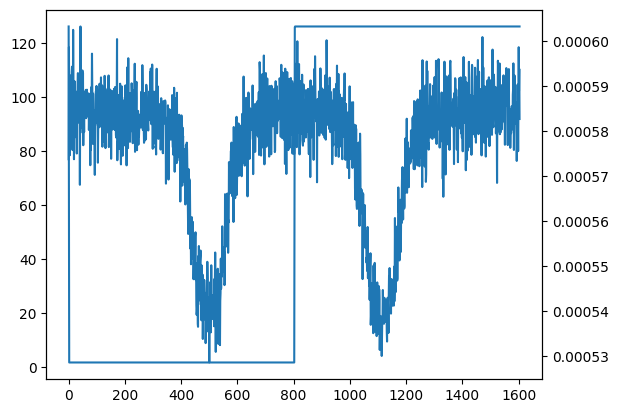

In [48]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(digital_data_av)
ax2.plot(analog_data_av)

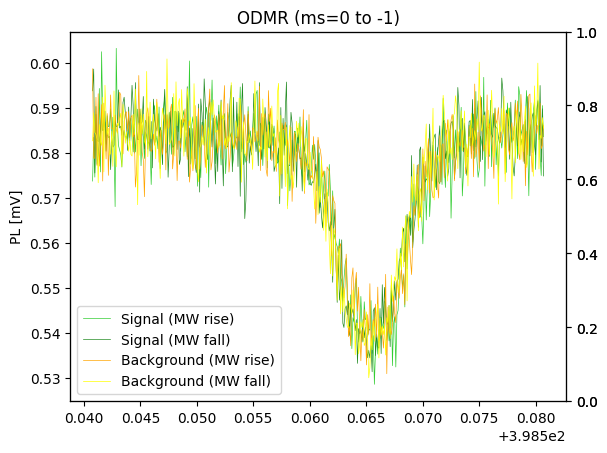

In [49]:


fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax3 = ax1.twinx()
# ax1.plot(analog_data_av*1E3, linewidth=0.5, label="signal", color="orange")
# ax2.plot(digital_data_av, linewidth=0.5, label="signal", color="green")
# ax1.plot(sigbg*1E3, linewidth=0.5, label="signal", color="red")
# ax3.plot(outtrig, linewidth=0.5, marker="*", label="signal", color="blue")

ax1.plot(freq, sig_rise*1E3, linewidth=0.5, label="Signal (MW rise)", color="limegreen")
ax1.plot(freq, sig_fall*1E3, linewidth=0.5, label="Signal (MW fall)", color="forestgreen")
ax1.plot(freq, bg_rise*1E3, linewidth=0.5, label="Background (MW rise)", color="orange")
ax1.plot(freq, bg_fall*1E3, linewidth=0.5, label="Background (MW fall)", color="yellow")
# ax2.plot(freq, contrast_mwrise*100.0, linewidth=1, label="contrast (MW rise)", color='royalblue')
# ax2.plot(freq, contrast_mwfall*100.0, linewidth=1, label="contrast (MW fall)", color='cornflowerblue')


# ax1.set_xlabel("Frequency [GHz]")
ax1.set_ylabel("PL [mV]")
# ax2.set_ylabel("Contrast [%]", color='royalblue')
ax1.legend(loc='lower left')
plt.title("ODMR (ms=0 to -1)")
plt.show()